In [1]:
push!(LOAD_PATH,".")
using ListType, OptionType, Chakra, Nova
using Viewpoints, PPM
using CSV, DataFrames
using Plots
using Profile

┌ Info: Precompiling PPM [top-level]
└ @ Base loading.jl:1423


In [2]:
melodies = map(fn->string("nova/",fn,"/track1"),readdir("nova"))
id_seqs = [obind(find(m,data),particles) for m in melodies]
seqs = [Chakra.sequence(s,data) for s in id_seqs]
pitch_view = [PPM.View(seq,vp(:pitch),vp(:pitch)) for seq in seqs];

# Parameters

In [3]:
a = Set([54:77...,79,81])
b = Backoff()
e = A()
u = false
o = Bounded(5)
#o = Unbounded();

# Short-term model

In [4]:
@time stm = PPM.ppm_stm(pitch_view,a,b,e,u,o);

  1.704747 seconds (13.39 M allocations: 1.362 GiB, 17.27% gc time, 32.57% compilation time)


# Long-term model

In [5]:
@time ltm = PPM.ppm_ltm(pitch_view,a,b,e,u,o,100);

Folding dataset...
  0.116581 seconds (9.16 k allocations: 1.162 MiB, 99.77% compilation time)
Creating dbs...
  6.940444 seconds (63.65 M allocations: 5.373 GiB, 31.72% gc time, 3.45% compilation time)
  8.619071 seconds (75.21 M allocations: 6.577 GiB, 29.36% gc time, 10.26% compilation time)


# Combined model

In [6]:
model = stm
#@time model = [[PPM.combine(Prediction[p1,p2];b=1) for (p1,p2) in zip(s,l)] for (s,l) in zip(stm,ltm)];

# Print table 

In [7]:
table = PPM.todataframe(model)

,SeqID,EventID,Symbol,Order,Prob,IC,H
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,1,65,-1,0.037037,4.75489,4.57878
2,1,2,62,-1,0.0192308,5.70044,3.2406
3,1,3,60,-1,0.0133333,6.22882,3.04986
4,1,4,60,0,0.25,2.0,3.07765
5,1,5,60,1,0.5,1.0,2.50685
6,1,6,60,2,0.5,1.0,2.50685
7,1,7,65,0,0.166667,2.58496,2.50685
8,1,8,65,0,0.142857,2.80735,1.99191
9,1,9,65,1,0.333333,1.58496,2.10768


In [8]:
symbols = table.Symbol
probabilities = table.Prob
orders = table.Order
df = CSV.File("./idyom-data/STMA5.csv") |> DataFrame;
idyom_probs = df[!,"probability"]
idyom_ics = df[!,"information.content"];
DataFrame(Symbol = symbols, IdyomProb = idyom_probs, JuliaProb = probabilities)

,Symbol,IdyomProb,JuliaProb
,Int64,Float64,Float64
1,65,0.0384615,0.037037
2,62,0.0196078,0.0192308
3,60,0.0135135,0.0133333
4,60,0.252632,0.25
5,60,0.503497,0.5
6,60,0.503497,0.5
7,65,0.167832,0.166667
8,65,0.143284,0.142857
9,65,0.334262,0.333333


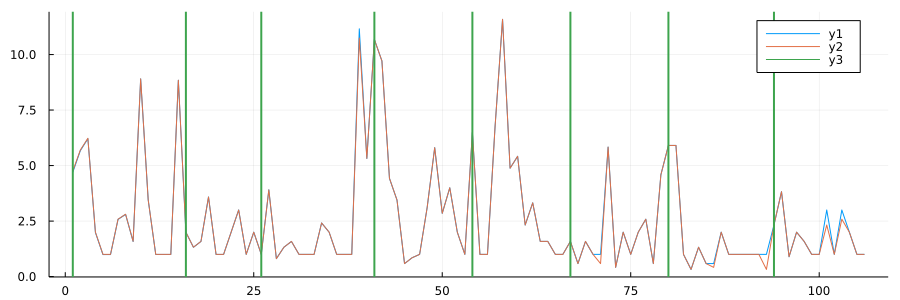

In [9]:
#base = length(a)
#logn = [log(base,x) for x in 1:106]
plot(idyom_ics[1:106])
plot!(table.IC[1:106])
#plot!(orders[500:600],lw = 3)
#plot!(logn,lw = 2)
idyom_phrase = findall(x->x==1,df[!,"phrase"][1:106]);
vline!(idyom_phrase, lw = 2)
plot!(size=(900,300))